# VGG16 Transfer Learning on MNIST Digit Recognition Dataset

## Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import os, time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import os

## Config GPU

In [70]:
!nvidia-smi

Sat May  1 23:37:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.92       Driver Version: 461.92       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070   WDDM  | 00000000:26:00.0  On |                  N/A |
|  0%   53C    P2    49W / 175W |   1163MiB /  8192MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Config using GPU 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15367286850812933982
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5233205954095259275
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3493421501537729717
physical_device_desc: "device: XLA_GPU device"
]


## Load Dataset & Preprocessing
Preprocessing: 
* Convert image from `1` channels to `3` channels
* Resize image from `(28,28)` to `(48,48)`
* Normalize dataset
* For label, using one-hot encoding


In [3]:
# read csv file
data_train = pd.read_csv(r"./data/train_new.csv") 
data_test = pd.read_csv(r"./data/test_new.csv") 
data_train.head()
data_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# shape
print('Train: ',data_train.shape)
print('Test: ',data_test.shape) 

Train:  (29400, 785)
Test:  (12600, 784)


In [5]:
# select & convert to numpy 
X_train = np.array(data_train.iloc[:,1:])
y_train = np.array(data_train.iloc[:,0])
X_test = np.array(data_test.iloc[:,0:])
y_test = np.array(data_test.iloc[:,0])

In [6]:
# convert vector img to 28x28
X_train = X_train.reshape(X_train.shape[0], 28,28)
X_test = X_test.reshape(X_test.shape[0], 28,28)
print(X_train.shape)
print(X_test.shape)

(29400, 28, 28)
(12600, 28, 28)


In [7]:
# one-hot encoding 
print('Number of classes: ',len(np.unique(y_train)) )
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)
print(y_train_oh)

Number of classes:  10
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [8]:
# Convert from 1 channel to 3 channel
X_train = np.stack((X_train,)*3, axis = -1)
X_test = np.stack((X_test,)*3, axis = -1)

print('Train ',X_train.shape)
print('Test ',X_test.shape)

Train  (29400, 28, 28, 3)
Test  (12600, 28, 28, 3)


In [9]:
# # Reshape to tensor 
X_train = X_train.reshape(-1,28,28,3)
X_test = X_test.reshape(-1,28,28,3)

# resize 28x28 to 48x48 required by VGG16
from keras.preprocessing.image import img_to_array, array_to_img
X_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in X_train])
X_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in X_test])

print(X_train.shape, X_test.shape)

(29400, 48, 48, 3) (12600, 48, 48, 3)


In [10]:
# Normalize dataset
X_train = X_train / 255.
X_test = X_test / 255.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [11]:
# train test split 
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train_oh,                                                                                          test_size= 0.3, 
                                                        random_state=42)

In [12]:
X_train.shape, y_train.shape

((20580, 48, 48, 3), (20580, 10))

# Load VGG16 pretrained model & modified model

## Feature Extraction

In [13]:
vgg16 = VGG16(weights='imagenet', input_shape=(48,48,3), include_top=False)
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

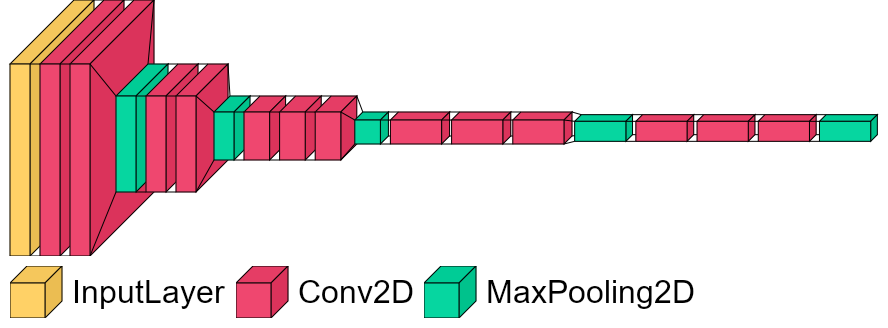

In [68]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)
# visualkeras.layered_view(vgg16).show() # display using your system viewer
visualkeras.layered_view(vgg16, to_file='vgg16.png') # write to disk
# visualkeras.layered_view(vgg16, to_file='output.png').show() # write and show
visualkeras.layered_view(vgg16,legend=True, font=font)

In [14]:
train_features = vgg16.predict(np.array(X_train), batch_size=8, verbose=1)
test_features = vgg16.predict(np.array(X_test), batch_size=8, verbose=1)
val_features = vgg16.predict(np.array(X_valid), batch_size=8, verbose=1)

1103/1103 [==============================] - 71s 64ms/step


In [15]:
# Saving the features 
np.savez("train_features", train_features, y_train)
np.savez("test_features", test_features, y_test)
np.savez("val_features", val_features, y_valid)

In [16]:
# # if already perform feature extraction
# train_features = np.load("train_features", train_features, y_train)
# test_features = np.load("test_features", test_features, y_test)
# val_features = np.load("val_features", val_features, y_valid)
# print(train_features.shape, test_features.shape, val_features.shape)

## Define new model 

In [17]:
from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers.advanced_activations import LeakyReLU

In [54]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(10, activation='softmax'))

# Compile the model.
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
  # optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

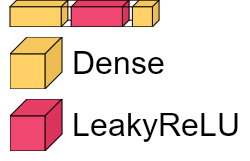

In [69]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)

# visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='dense.png') # write to disk
# visualkeras.layered_view(model, to_file='output.png').show() # write and show
visualkeras.layered_view(model, legend=True, font=font)

## Training

In [52]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='./model/vgg16.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [53]:
# Current shape of features
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

(20580, 1, 1, 512) 
 (12600, 1, 1, 512) 
 (8820, 1, 1, 512)


In [32]:
# Flatten extracted features
train_features_flat = np.reshape(train_features, (20580, 1*1*512))
test_features_flat = np.reshape(test_features, (12600, 1*1*512))
val_features_flat = np.reshape(val_features, (8820, 1*1*512))
print(train_features_flat.shape, "\n",  test_features_flat.shape, "\n", val_features_flat.shape)

(20580, 512) 
 (12600, 512) 
 (8820, 512)


In [33]:
print(y_train.shape, "\n", y_valid.shape)

(20580, 10) 
 (8820, 10)


In [56]:
# Train the the model
history = model.fit(
    train_features_flat,
    y_train,
    epochs=50,
    batch_size = 64,
    validation_data=(val_features_flat, y_valid),
    callbacks=my_callbacks
)

Epoch 1/50
322/322 [==============================] - 2s 5ms/step - loss: 0.4665 - acc: 0.8665 - val_loss: 0.2051 - val_acc: 0.9396
Epoch 2/50
322/322 [==============================] - 1s 3ms/step - loss: 0.1774 - acc: 0.9473 - val_loss: 0.1487 - val_acc: 0.9531
Epoch 3/50
322/322 [==============================] - 1s 3ms/step - loss: 0.1316 - acc: 0.9611 - val_loss: 0.1493 - val_acc: 0.9524
Epoch 4/50
322/322 [==============================] - 1s 3ms/step - loss: 0.1128 - acc: 0.9657 - val_loss: 0.1186 - val_acc: 0.9630
Epoch 5/50
322/322 [==============================] - 1s 3ms/step - loss: 0.0976 - acc: 0.9707 - val_loss: 0.1268 - val_acc: 0.9583
Epoch 6/50
322/322 [==============================] - 1s 3ms/step - loss: 0.0872 - acc: 0.9726 - val_loss: 0.1205 - val_acc: 0.9620


## Evaluation

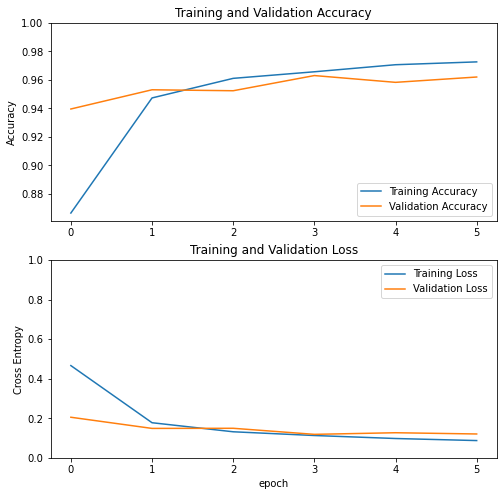

<Figure size 432x288 with 0 Axes>

In [58]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
plt.savefig('batch64_epoch50')

##  Generate submission

In [44]:
vgg16_predict_result = vgg16.predict(X_test)

In [45]:
result = model.predict(vgg16_predict_result)
result.shape

(12600, 1, 1, 10)

In [46]:
#convert prediction to array
res = []
for ele in result: 
    tmp = np.argmax(ele[0])
    res.append(tmp)

res = np.array(res)
print(res.shape)

(12600,)


In [47]:
# result = model.predict(X_test)
# image_id = []
# for i in range(data_test.shape[0]):
#   image_id.append(i + 1)
# image_id = np.array(image_id)
# result_df = pd.DataFrame({'ImageId': image_id, 'Label': result})
# result_df.to_csv('result.csv')

image_id = []
for i in range(data_test.shape[0]):
  image_id.append(i + 1)
image_id = np.array(image_id)
result_df = pd.DataFrame({'ImageId': image_id, 'Label': res})
result_df.to_csv('result2.csv')